In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Test

To evaluate different combinations of retransmission parameters, I will first use a subset of all test data to conduct a trial and check the data's usability.

In [2]:
file_path = '6.csv'

data = pd.read_csv(file_path)
data.head()

,MaxRetryCount,RetryInterval,Iteration,FailedMessagesCount
0,6,5s,1,0
1,6,5s,2,1
2,6,5s,3,0
3,6,5s,4,1
4,6,5s,5,1


In [3]:
data['MessageCount'] = 5000

data['CorrectMessagesCount'] = data['MessageCount'] - data['FailedMessagesCount']
data['ErrorRate'] = data['FailedMessagesCount'] / data['MessageCount']
data['CorrectRate'] = data['CorrectMessagesCount'] / data['MessageCount']

In [4]:
data.head()

,MaxRetryCount,RetryInterval,Iteration,FailedMessagesCount,MessageCount,CorrectMessagesCount,ErrorRate,CorrectRate
0,6,5s,1,0,5000,5000,0.0000,1.0000
1,6,5s,2,1,5000,4999,0.0002,0.9998
2,6,5s,3,0,5000,5000,0.0000,1.0000
3,6,5s,4,1,5000,4999,0.0002,0.9998
4,6,5s,5,1,5000,4999,0.0002,0.9998


In [5]:
summary = data.groupby(['MaxRetryCount', 'RetryInterval']).agg(
    TotalIterations=('Iteration', 'count'),
    TotalFailedMessages=('FailedMessagesCount', 'sum'),
    TotalCorrectMessages=('CorrectMessagesCount', 'sum'),
    AverageErrorRate=('ErrorRate', 'mean'),
    AverageCorrectRate=('CorrectRate', 'mean')
).reset_index()

In [6]:
summary

,MaxRetryCount,RetryInterval,TotalIterations,TotalFailedMessages,TotalCorrectMessages,AverageErrorRate,AverageCorrectRate
0,6,1s,50,93,249907,0.000372,0.999628
1,6,2s,50,24,249976,0.000096,0.999904
2,6,3s,50,2,249998,0.000008,0.999992
3,6,4s,50,7,249993,0.000028,0.999972
4,6,5s,50,15,249985,0.000060,0.999940


According to the table above, we can clearly see the message success rates for different retry intervals when the retry count is 6 times.

In the following step, I will process all the data and use a line chart to visualize the success rates under different retry intervals with different retry counts. This will facilitate the comparison of the experimental results.

# Experiment

The testing of the retransmission mechanism is divided into two parts. The first part is to find the smallest combination of retry count and retry interval parameters. The second part is to compare the message success rate under conditions with and without the retransmission mechanism. To improve the reliability of the experimental results, each test task will be conducted multiple times, and relevant data will be collected for analysis. For example, when searching for the optimal retransmission mechanism parameters, each parameter set will be tested 50 times, sending 5000 messages each time, and finally calculating the average success rate of these 50 tests.

## Experiment 1 - Identifying Optimal Retransmission Parameters

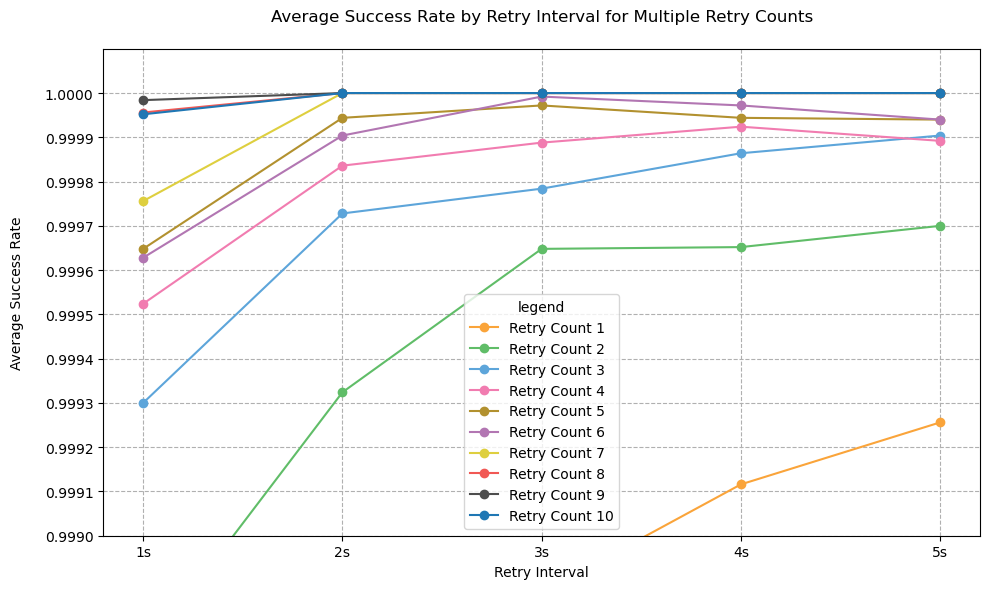

In [7]:
colors = ['#FAA43A', '#60BD68', '#5DA5DA', '#F17CB0', '#B2912F', '#B276B2', '#DECF3F', '#F15854', '#4D4D4D', '#1F77B4']

plt.figure(figsize=(10, 6))

for i in range(10):
    file_path = f'{i+1}.csv'
    data = pd.read_csv(file_path)
    
    data['MessageCount'] = 5000
    
    data['CorrectMessagesCount'] = data['MessageCount'] - data['FailedMessagesCount']
    data['ErrorRate'] = data['FailedMessagesCount'] / data['MessageCount']
    data['SuccessRate'] = data['CorrectMessagesCount'] / data['MessageCount']
    
    summary = data.groupby(['MaxRetryCount', 'RetryInterval']).agg(
        TotalIterations=('Iteration', 'count'),
        TotalFailedMessages=('FailedMessagesCount', 'sum'),
        TotalCorrectMessages=('CorrectMessagesCount', 'sum'),
        AverageErrorRate=('ErrorRate', 'mean'),
        AverageSuccessRate=('SuccessRate', 'mean')
    ).reset_index()

    plt.plot(summary['RetryInterval'], summary['AverageSuccessRate'], marker='o', label=f'Retry Count {i+1}', color=colors[i])

plt.yticks(np.arange(0.99900, 1.00010, 0.00010))
plt.xlabel('Retry Interval')
plt.ylabel('Average Success Rate', labelpad=15)
plt.title('Average Success Rate by Retry Interval for Multiple Retry Counts', pad=20)
# plt.ylim(0.999500, 1.000050)
plt.ylim(0.99900, 1.00010)
plt.legend(title='legend')
plt.grid(True, which='both', linestyle='--', linewidth=0.8)
plt.tight_layout()

plt.savefig('average_success_rate.png')

plt.show()

According to the graph above, we can see that as the number of retransmissions decreases, the message success rate continuously declines. In our system, the message success rate must remain at 100 percent. Based on this goal, we will identify the smallest values for these two parameters within a series of retry count and retry interval combinations that ensure a 100 percent success rate.

When the retry count is greater than or equal to 7 times and the retry interval is more than or equal to 2 seconds, the message success rate is 100 percent. When all messages can be successfully delivered, the values of retry count and retry interval should be as small as possible, as retransmissions waste system resources. Therefore, the optimal retry count is 7 times and the retry interval is 2 seconds.

## Experiment 2 - Comparing Success Rates with and without Retransmission Mechanism

Firstly, conduct 50 tests using the system without retransmission mechanism. In each test, send 5000 messages. Then, collect all the test data. Finally, calculate the average message success rate for these 50 tests.

In [8]:
non_retransmission = pd.read_csv('non-retransmission.csv')
non_retransmission['MessageCount'] = 5000
non_retransmission['CorrectMessagesCount'] = non_retransmission['MessageCount'] - non_retransmission['FailedMessagesCount']
non_retransmission['SuccessRate'] = non_retransmission['CorrectMessagesCount'] / non_retransmission['MessageCount']

In [9]:
non_retransmission.head()

,Iteration,FailedMessagesCount,MessageCount,CorrectMessagesCount,SuccessRate
0,1,0,5000,5000,1.0000
1,2,2227,5000,2773,0.5546
2,3,4292,5000,708,0.1416
3,4,0,5000,5000,1.0000
4,5,2733,5000,2267,0.4534


In [10]:
average_non_retransmission = non_retransmission['SuccessRate'].mean()
average_non_retransmission

0.6284000000000001

After that, calculate the average message success rate for the system with the retransmission mechanism. It is worth noting that the parameter combination used here is obtained from the first experiment, which is a maximum of 7 retries with a 2-second interval between each retry.

In [11]:
retransmission = pd.read_csv('7.csv')
retransmission = retransmission[retransmission['RetryInterval'] == '2s']
retransmission.head()

,MaxRetryCount,RetryInterval,Iteration,FailedMessagesCount
150,7,2s,1,0
151,7,2s,2,0
152,7,2s,3,0
153,7,2s,4,0
154,7,2s,5,0


In [12]:
retransmission['MessageCount'] = 5000
retransmission['CorrectMessagesCount'] = retransmission['MessageCount'] - retransmission['FailedMessagesCount']
retransmission['SuccessRate'] = retransmission['CorrectMessagesCount'] / retransmission['MessageCount']
average_retransmission = retransmission['SuccessRate'].mean()

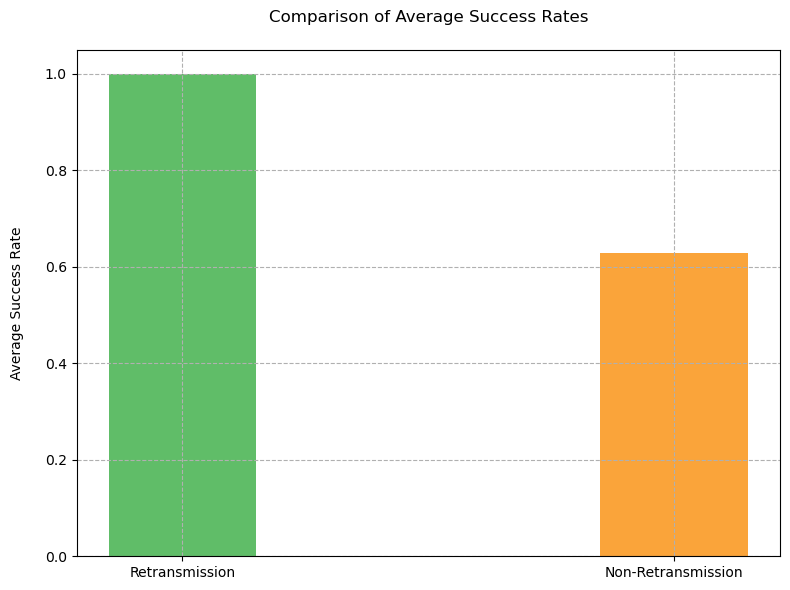

In [13]:
plt.figure(figsize=(8, 6))
categories = ['Retransmission', 'Non-Retransmission']
success_rates = [average_retransmission, average_non_retransmission]
plt.bar(categories, success_rates, color=['#60BD68', '#FAA43A'], width=0.3)
plt.ylabel('Average Success Rate', labelpad=15)
plt.title('Comparison of Average Success Rates', pad=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.8)
plt.tight_layout()

plt.savefig('success_rate_comparison_chart.png')

plt.show()

According to the graph above, it is clear that the message success rate in the system with the retransmission mechanism is significantly higher than in the system without it. The success rate with the retransmission mechanism reaches 100%, whereas without it, the success rate is a little more than 60%.

Therefore, it is necessary to set up a retransmission mechanism inside the system, though sometimes it may affect the performance negatively.